# Summary Report

## Introduction

In this paper, I used the IMDB dataset of movie review to build a NLP model to classify the sentiment of movie reviews into either positive or negative. I took a pre-trained BERT model and fine-tune it using _TensorFlow_. Within the limited time and resource, I tested with several choices of model and hyperparameters and chose the best model with highest accuracy in validation set. For this analysis, I extensively used [classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) tutorial from TensorFlow hub (2022).

## Data Collection and Preparation

I collected the IMDB dataset from ['Large Movie Review Dataset'](https://ai.stanford.edu/~amaas/data/sentiment/) (Andrew et al., 2011). The main directory has two separate folder: train and test with 25000 entry each, which corresponds to training and testing datasets. Each folder has two subfolders for positive and negative reviews. Then, I created a validation set by taking 20% entry from the training dataset. Thus finally, my training set, validation set and test set have a total of 20000, 5000 and 25000 entry respectively. I will train the model (i.e., fine-tune the parameters) primarily using the training set. To chose a better model architecture and/or hyperparameter values, we will evaluate different models with the validation set and chose the best one. Lastly, once we chose the final model, we can evaluate its unbiased performance using the unseen test set. At first, I chose the batch size as 32. 


## Base Model 

As suggested by TensorFlow (2022), I started using one of the [Small BERT](https://tfhub.dev/google/collections/bert/2) models (Turc et al, 2019), which uses similar architecture of original BERT model (Devlin et al., 2018), but with a smaller number of transformer block (denoted by _L_), smaller hidden embedding size (_H_) and corresponding number of attention head (_A_). Similarly I used their corresponding preprocessing model provided by TensorFlow, which will standardize (remove punctuations, HTML tags, etc.), tokenize (splitting the sentence into individual words, add special tokens) and vectorize (embadding each tokens into same-size vectors) the input.

Two important output from BERT models are *pooled_output* and *sequence_output*. Each value of *pooled_output* corresponds to an entire single movie review, where the *sequence_output* corresponds to every token in the reviews. As we want to classify the sentiment of the review, we want a single output for a single review. This is why we added a linear layer add the end of the BERT model, which will take the *pooled_output* as an input and output a single number for each review. In order to avoid over-fitting, we used a dropout layer before this linear layer with a dropout rate of 0.2. As the final expected outcome is binary (either positive or negative), we need to transform our output between 0 to 1. Thus we used the sigmoid activation function in the last layer. If our expected outcome was a multi-level classification, we need to use softmax in our last layer to get a probability distribution.


Our true label is binary and the sigmoid output of our BERT model is a probability between 0 to 1. So, as a loss function, we can use the binary cross entropy as it will penalize a higher deviation from the true label. For accuracy measurement, we can simply calculate the binary accuracy using a default 0.5 threshold. When the predicted sigmoid output is equal or higher than 0.5, it is positive (1) and otherwise negative (0) review.

We will use the AdamW optimizer (Adam with weight decay instead of momentum) as suggested by the original BERT paper (Devlin et al, 2018) with a linear scheduler. We start with an initial learning rate, then over the total training steps _(epoch*batch size)_, it linearly decreases to 0.

## Model Comparison Summary

To find a better model, I tweaked some of the hyperparameters and model architectures using the limited resource of Google Colab. I tried with two different small BERT model: the number of transformer block, L equals six and eight. I changed the initial learning rate around the suggested value of _3e-5_. I also tried with and without the scheduler and with a higher dropout rate. The runtime and validation accuracy after training of 3 epochs are reported in the following table:

Model No. | Batch Size | Model | Initial Learning Rate | Scheduler | Dropout Rate | Epoch | Validation Accuracy| Runtime (min) |
---|---|---|---|---|---|---|---|---|
1 | 32 | L=6, H=512, A=8 | 3e-5 | yes | 0.2 | 3 | 0.8532| 21.43 |
2 | 32 | L=6, H=512, A=8 | 3e-4 | yes | 0.2 | 3 | 0.8284| 21.15 |
3 | 32 | L=6, H=512, A=8 | 5e-5 | yes | 0.2 | 3 | 0.8552 | 20.8 |
4 | 32 | L=6, H=512, A=8 | 5e-5 | No | 0.2 | 3 | 0.8516 | 20.9 |
5 | 32 | L=8, H=512, A=8 | 5e-5 | yes | 0.2 | 3 | 0.8626 | 26.6 |
6 | 32 | L=8, H=512, A=8 | 7e-5 | yes | 0.3 | 3 | 0.8554 | 26.51 |
7 | 32 | L=8, H=512, A=8 | 3e-5 | yes | 0.3 | 3 | 0.8510 | 26.51 |
8 | 32 | L=12, H=512, A=8 | 5e-5 | yes | 0.2 | 3 | **0.8632** | 37.51 |


We can see that as we increase the number of transformer blocks, the runtime increases but overall the accuracy also increases. The accuracy with a learning rate close to $10^{-4}$ (model 2) is  much lower than the models with a smaller learning rate ($10^{-5}$). Moreover, the suggestion from the original BERT paper is also in the magnitude of $10^{-5}$.

Comparing the validation accuracy among these models, model 8 is the best model with L=12 (12 transformer blocks), initial learning rate of $5 \times 10^{-5}$. But one thing to note that the runtime increases almost 1.5 times than model 5, where their validation accuracy is very close. Perhaps, maybe the accuracy could improve if we can optimize the hyperparameters for this BERT model.

## Results

The loss and accuracy for the train, validation and test dataset using model 8 are reported in the following Table.

Dataset | Loss | Accuracy 
---|---|---
Train | 0.1421 | 0.9507 |
Validation | 0.4901 | 0.8632 |
Test | 0.4659 | 0.8673 |

## Discussion and Future Work

The accuracy in both validation and test set is around 86% with our model.

One major limitation of our model is that we only tried with two different model and the hyperparameter space is not explored very well due to limited time and resources. With a better hyperparameter choice, we could possibly cross the 90% benchmark.

If I have more time and more computational resources, then I can better explore the hyperparameter. Instead of choosing all the hyperparamters each time, I would do a randomized search. First I will define the range of interest (or all possible choices) for each of the hyperparameter. For example, dropout rate = $[0, 0.4]$, batch size = {$8,16,32,64$}, scheduler = {yes, no}, initial learning rate = $[2,7]\times 10^{-5}$. Then I would choose a number of iteration (maybe start with iter = 10). In each iteration, I will randomly chose the value of each hyperparameter from the given range (or set), train the model and find validation accuracy. Finally we can chose the model with the best validation accuracy.

I would also change the model architectures. Here I only had chance to play with two different BERT model. Ideally, I would choose more different BERT models (maybe choose from L = {6,8,10,12}, H={512,768}, A={8,12}) and compare the best validation accuracy for each model to chose the final model.

Another insight that I found is that it is better to search with a larger range with only 1 or 2 epoch. Then we can do more granular search with 3 or 5 epoch.

## Reference


* Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. _The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)_ http://www.aclweb.org/anthology/P11-1015


* TensorFlow Tutorial (2022), Classify Text with BERT. Retrieved from: https://www.tensorflow.org/text/tutorials/classify_text_with_bert


* Devlin, J., Chang, M., Lee, K., Toutanova, K., (2018). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018. https://arxiv.org/abs/1810.04805


* Turc, I., Chang, M., Lee, K., Toutanova, K. (2019). "Well-Read Students Learn Better: On the Importance of Pre-training Compact Models". https://arxiv.org/abs/1908.08962

# Data Collection and Preparation

## Loading Necessary packages

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"


In [ ]:
!pip install -q tf-models-official==2.7.0


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


tf.get_logger().setLevel('ERROR')

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from google.colab import files


## Loading the dataset
Loaded from ['Large Movie Review Dataset'](https://ai.stanford.edu/~amaas/data/sentiment/) (Andrew et al., 2011).

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
# cheking the folders
os.listdir(dataset_dir)

['test', 'README', 'train', 'imdbEr.txt', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir) # checking the subfolders

['unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt',
 'neg']

In [ ]:
# remove subfolders other than positive and negative review
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

## Train, Validation and Test Subset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


# Fine-tuning BERT Model 

## Loading pre-trained BERT Model

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/3',
    'electra_small':
        'https://tfhub.dev/google/electra_small/3',
    'electra_base':
        'https://tfhub.dev/google/electra_base/3',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Define our model

In [ ]:
def build_classifier_model(dropout_rate = 0.2):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout_rate)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Model Training

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model = build_classifier_model()

In [ ]:
classifier_model.summary() 

In [ ]:
tf.keras.utils.plot_model(classifier_model, show_shapes = True, show_layer_activations=True)


In [ ]:
# loss and accuracy function

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

#### Loss Curve

In [ ]:
def plot_loss_curve(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(8, 8))
    # fig.tight_layout()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### Model 1

In [ ]:
# optimizer

epochs = 3
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Epoch 1/4
625/625 [==============================] - 443s 690ms/step - loss: 0.4595 - binary_accuracy: 0.7725 - val_loss: 0.3636 - val_binary_accuracy: 0.8384
Epoch 2/4
625/625 [==============================] - 421s 674ms/step - loss: 0.3058 - binary_accuracy: 0.8712 - val_loss: 0.3564 - val_binary_accuracy: 0.8502
Epoch 3/4
625/625 [==============================] - 422s 675ms/step - loss: 0.2209 - binary_accuracy: 0.9149 - val_loss: 0.4044 - val_binary_accuracy: 0.8532
Epoch 4/4
625/625 [==============================] - 421s 674ms/step - loss: 0.1587 - binary_accuracy: 0.9409 - val_loss: 0.4602 - val_binary_accuracy: 0.8560


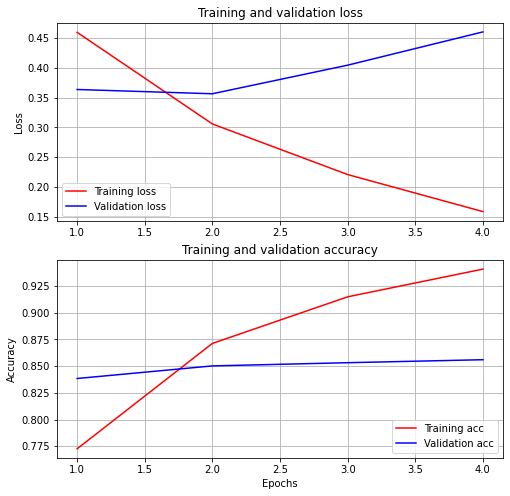

In [ ]:
plot_loss_curve(history)

### Model 2

In [ ]:
classifier_model_2 = build_classifier_model()

epochs = 3
init_lr = 3e-4
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.05*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model_2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_2.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Epoch 1/3
625/625 [==============================] - 428s 675ms/step - loss: 0.4255 - binary_accuracy: 0.8274 - val_loss: 0.6229 - val_binary_accuracy: 0.7636
Epoch 2/3
625/625 [==============================] - 421s 673ms/step - loss: 0.3425 - binary_accuracy: 0.8686 - val_loss: 0.4872 - val_binary_accuracy: 0.8230
Epoch 3/3
625/625 [==============================] - 420s 672ms/step - loss: 0.2519 - binary_accuracy: 0.9136 - val_loss: 0.4713 - val_binary_accuracy: 0.8284


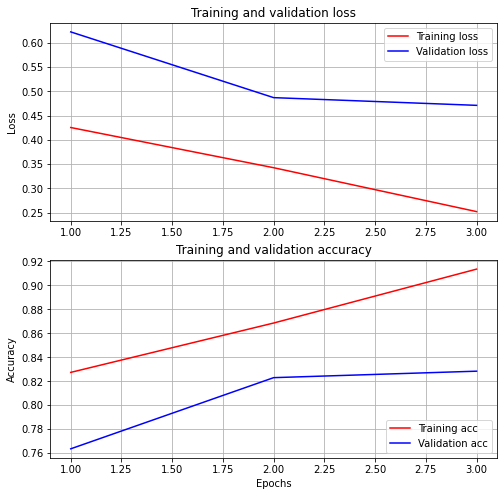

In [ ]:
plot_loss_curve(history)

### Model 3

In [ ]:
classifier_model_3 = build_classifier_model()

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_3.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/2
Epoch 1/3
625/625 [==============================] - 422s 660ms/step - loss: 0.4475 - binary_accuracy: 0.7909 - val_loss: 0.3486 - val_binary_accuracy: 0.8432
Epoch 2/3
625/625 [==============================] - 414s 663ms/step - loss: 0.2847 - binary_accuracy: 0.8831 - val_loss: 0.3727 - val_binary_accuracy: 0.8502
Epoch 3/3
625/625 [==============================] - 412s 659ms/step - loss: 0.1779 - binary_accuracy: 0.9355 - val_loss: 0.4402 - val_binary_accuracy: 0.8552


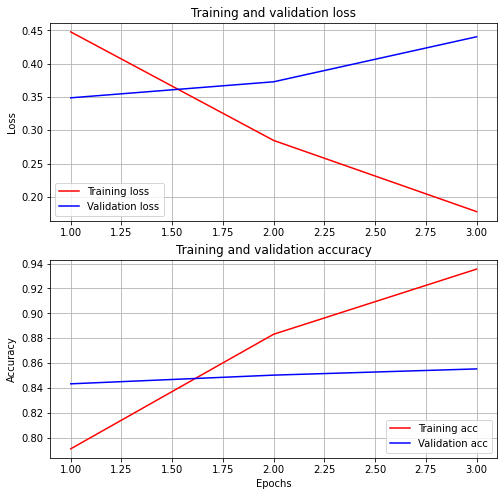

In [ ]:
plot_loss_curve(history)

### Model 4

In [ ]:
classifier_model_4 = build_classifier_model()

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          end_lr = init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=0,
                                          optimizer_type='adamw')
classifier_model_4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_4.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/2
Epoch 1/3
625/625 [==============================] - 424s 670ms/step - loss: 0.1765 - binary_accuracy: 0.9226 - val_loss: 0.5180 - val_binary_accuracy: 0.8542
Epoch 2/3
625/625 [==============================] - 416s 665ms/step - loss: 0.1374 - binary_accuracy: 0.9571 - val_loss: 0.7288 - val_binary_accuracy: 0.8416
Epoch 3/3
625/625 [==============================] - 414s 662ms/step - loss: 0.1177 - binary_accuracy: 0.9654 - val_loss: 0.7729 - val_binary_accuracy: 0.8516


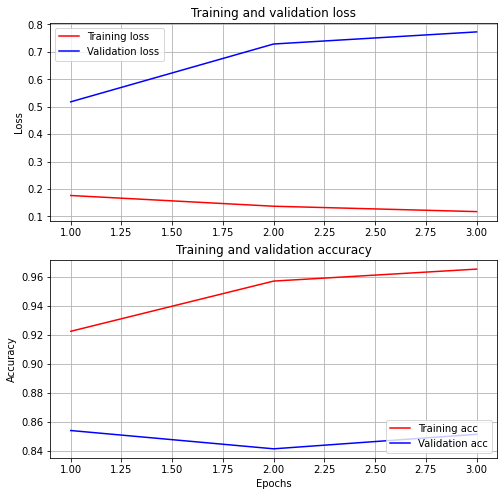

In [ ]:
plot_loss_curve(history)

### Model 5

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model_5 = build_classifier_model()

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_5.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Epoch 1/3
625/625 [==============================] - 538s 840ms/step - loss: 0.4260 - binary_accuracy: 0.8104 - val_loss: 0.3553 - val_binary_accuracy: 0.8452
Epoch 2/3
625/625 [==============================] - 525s 840ms/step - loss: 0.2614 - binary_accuracy: 0.8942 - val_loss: 0.3794 - val_binary_accuracy: 0.8552
Epoch 3/3
625/625 [==============================] - 533s 852ms/step - loss: 0.1574 - binary_accuracy: 0.9444 - val_loss: 0.4644 - val_binary_accuracy: 0.8626


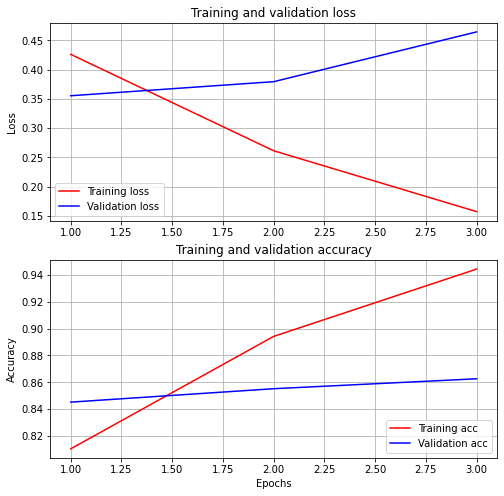

In [ ]:
plot_loss_curve(history)

### Model 6

In [ ]:
classifier_model_6 = build_classifier_model(dropout_rate=0.3)

init_lr = 7e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_6.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_6.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Epoch 1/3
625/625 [==============================] - 541s 844ms/step - loss: 0.4545 - binary_accuracy: 0.7979 - val_loss: 0.3560 - val_binary_accuracy: 0.8454
Epoch 2/3
625/625 [==============================] - 525s 841ms/step - loss: 0.2702 - binary_accuracy: 0.8907 - val_loss: 0.3859 - val_binary_accuracy: 0.8520
Epoch 3/3
625/625 [==============================] - 525s 840ms/step - loss: 0.1503 - binary_accuracy: 0.9471 - val_loss: 0.4748 - val_binary_accuracy: 0.8554


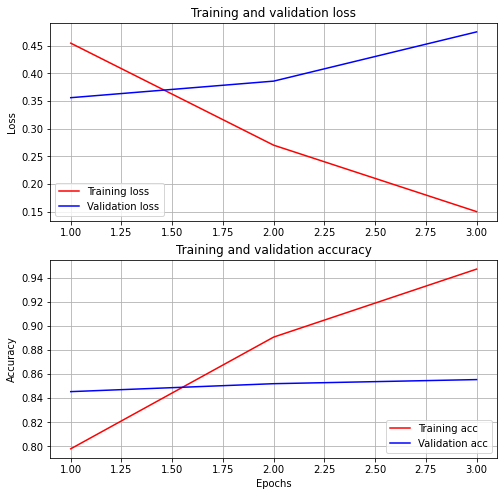

In [ ]:
plot_loss_curve(history)

### Model 7

In [ ]:
classifier_model_7 = build_classifier_model(dropout_rate=0.3)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_7.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_7.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Epoch 1/3
625/625 [==============================] - 541s 843ms/step - loss: 0.4467 - binary_accuracy: 0.7970 - val_loss: 0.3553 - val_binary_accuracy: 0.8486
Epoch 2/3
625/625 [==============================] - 526s 842ms/step - loss: 0.2833 - binary_accuracy: 0.8809 - val_loss: 0.3855 - val_binary_accuracy: 0.8496
Epoch 3/3
625/625 [==============================] - 524s 838ms/step - loss: 0.1920 - binary_accuracy: 0.9258 - val_loss: 0.4297 - val_binary_accuracy: 0.8510


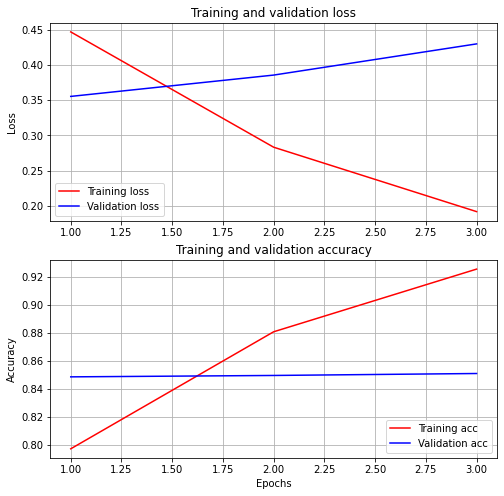

In [ ]:
plot_loss_curve(history)

### Model 8

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model_8 = build_classifier_model()

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
epochs = 3
init_lr = 5e-5
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_8.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_8.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1
Epoch 1/3
625/625 [==============================] - 396s 603ms/step - loss: 0.4352 - binary_accuracy: 0.7929 - val_loss: 0.3424 - val_binary_accuracy: 0.8486
Epoch 2/3
625/625 [==============================] - 372s 596ms/step - loss: 0.2516 - binary_accuracy: 0.8974 - val_loss: 0.3886 - val_binary_accuracy: 0.8494
Epoch 3/3
625/625 [==============================] - 372s 595ms/step - loss: 0.1344 - binary_accuracy: 0.9528 - val_loss: 0.4909 - val_binary_accuracy: 0.8624


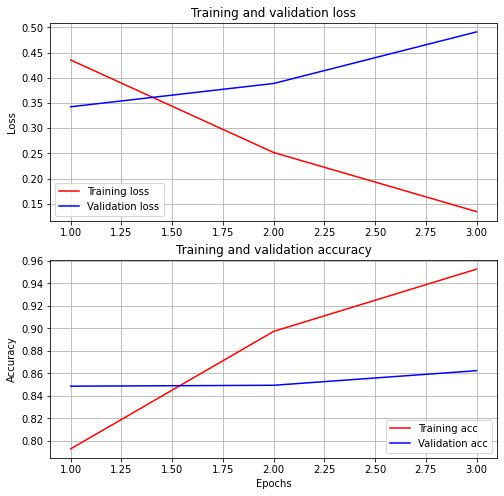

In [ ]:
plot_loss_curve(history)

### Model 9

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model_9 = build_classifier_model()

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
epochs = 3
init_lr = 3e-5
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_9.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_9.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/3
625/625 [==============================] - 648s 1s/step - loss: 0.3902 - binary_accuracy: 0.8140 - val_loss: 0.2925 - val_binary_accuracy: 0.8820
Epoch 2/3
625/625 [==============================] - 637s 1s/step - loss: 0.2068 - binary_accuracy: 0.9192 - val_loss: 0.3219 - val_binary_accuracy: 0.8866
Epoch 3/3
625/625 [==============================] - 636s 1s/step - loss: 0.1121 - binary_accuracy: 0.9647 - val_loss: 0.4408 - val_binary_accuracy: 0.8876


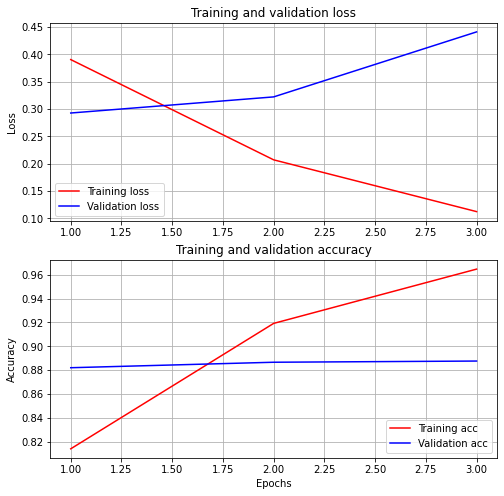

In [ ]:
plot_loss_curve(history)

### Model 10

In [ ]:
bert_model_name = 'albert_en_base' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model_10 = build_classifier_model()

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [ ]:
epochs = 3
init_lr = 3e-5
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_10.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_10.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/albert_en_base/3
Epoch 1/3
625/625 [==============================] - 735s 1s/step - loss: 0.3869 - binary_accuracy: 0.8324 - val_loss: 0.2882 - val_binary_accuracy: 0.8742
Epoch 2/3
625/625 [==============================] - 733s 1s/step - loss: 0.2344 - binary_accuracy: 0.9062 - val_loss: 0.3085 - val_binary_accuracy: 0.8806
Epoch 3/3
625/625 [==============================] - 734s 1s/step - loss: 0.1347 - binary_accuracy: 0.9546 - val_loss: 0.3983 - val_binary_accuracy: 0.8800


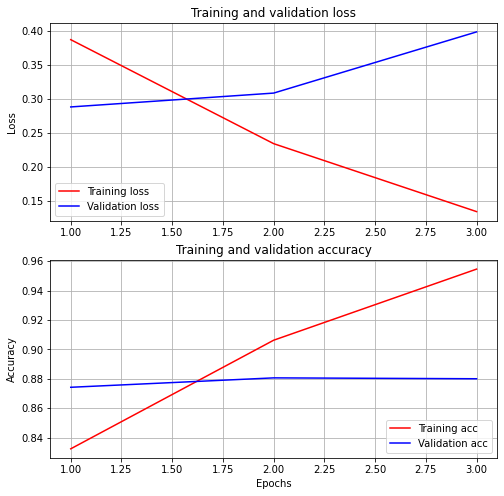

In [ ]:
plot_loss_curve(history)

### Hyperparameter Optimization


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def get_random_params(params={}, lr_range = (-3, -6), 
                      drop_range = (0,0.4)):
    if 'dropout_rate' not in params.keys():
        params['dropout_rate'] = np.random.uniform(drop_range[0],drop_range[1])
    if 'init_lr' not in params.keys():
        params['init_lr'] = 10**np.random.uniform(lr_range[0],lr_range[1])
    return params

In [ ]:
params = get_random_params(params={'dropout_rate': 0.2})
params

{'dropout_rate': 0.2, 'init_lr': 1.1442137042130719e-05}

In [ ]:
lr_range = (-3.5, -5.5)
np.random.uniform(lr_range[0],lr_range[1])

-5.433981918910591

In [ ]:

def run_NLP_model(params, epochs = 2):
    classifier_model =  build_classifier_model(params['dropout_rate'])

    steps_per_epoch = len(train_ds)             # number of total batches
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=params['init_lr'],
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    print(f'Training model with {tfhub_handle_encoder}')
    print(params)

    start_time = time.time()
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)
    runtime = time.time() - start_time

    plot_loss_curve(history)
    val_acc = history.history['val_binary_accuracy']

    return classifier_model, val_acc, runtime

### Original Bert (L=12, H=768, A=12) 

Learning Rate Primary Optimization

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
init_lr_list = np.array(10**np.linspace(-3,-6, 5), dtype='float32')
init_lr_list.dtype

dtype('float32')

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 0.001}
Epoch 1/2
625/625 [==============================] - 638s 998ms/step - loss: 0.7496 - binary_accuracy: 0.5828 - val_loss: 0.6931 - val_binary_accuracy: 0.5076
Epoch 2/2
625/625 [==============================] - 623s 997ms/step - loss: 0.7242 - binary_accuracy: 0.5039 - val_loss: 0.6935 - val_binary_accuracy: 0.4924


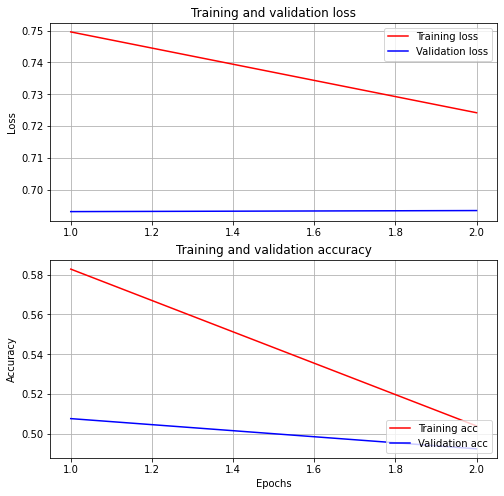

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 0.00017782794}
Epoch 1/2
625/625 [==============================] - 654s 1s/step - loss: 0.4117 - binary_accuracy: 0.7500 - val_loss: 0.3159 - val_binary_accuracy: 0.8688
Epoch 2/2
625/625 [==============================] - 628s 1s/step - loss: 0.1907 - binary_accuracy: 0.9281 - val_loss: 0.3674 - val_binary_accuracy: 0.8820


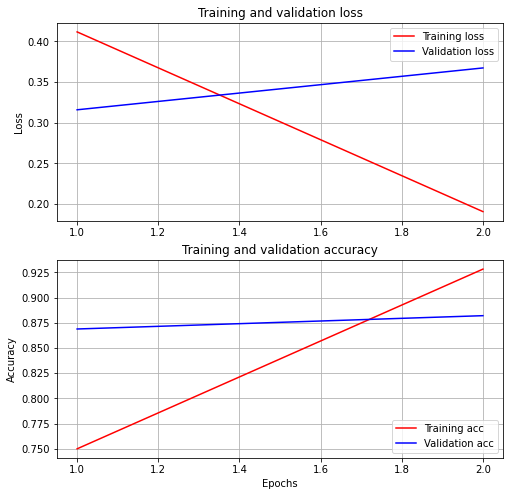

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 3.1622778e-05}
Epoch 1/2
625/625 [==============================] - 641s 1s/step - loss: 0.3626 - binary_accuracy: 0.8402 - val_loss: 0.2813 - val_binary_accuracy: 0.8830
Epoch 2/2
625/625 [==============================] - 627s 1s/step - loss: 0.1906 - binary_accuracy: 0.9262 - val_loss: 0.3140 - val_binary_accuracy: 0.8864


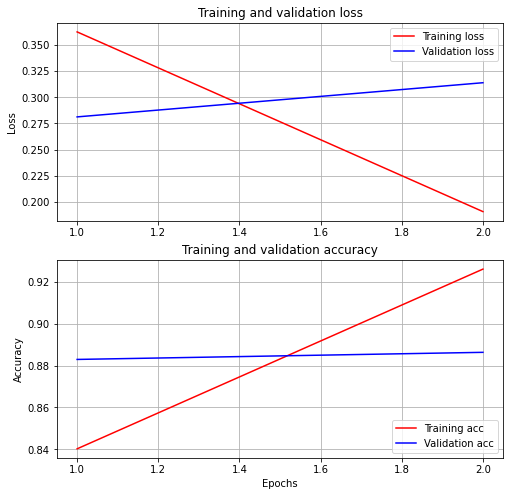

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 5.6234135e-06}
Epoch 1/2
625/625 [==============================] - 644s 1s/step - loss: 0.4387 - binary_accuracy: 0.7997 - val_loss: 0.3235 - val_binary_accuracy: 0.8606
Epoch 2/2
625/625 [==============================] - 627s 1s/step - loss: 0.2939 - binary_accuracy: 0.8767 - val_loss: 0.3203 - val_binary_accuracy: 0.8666


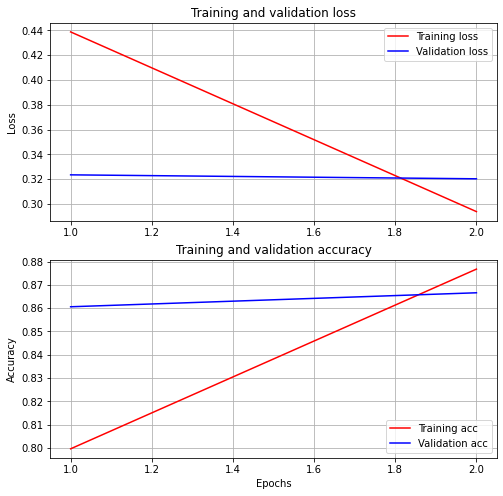

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 1e-06}
Epoch 1/2


ResourceExhaustedError: ignored

In [ ]:
classifier_model_list = []
val_acc_list = []
param_list = []

for i in range(5):
    params={'dropout_rate': 0.2, 'init_lr':init_lr_list[i]}
    param_list.append(params)

    classifier_model, val_acc = run_NLP_model(params)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


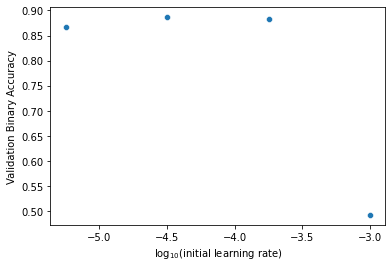

In [ ]:
val_acc_list_final = [val_acc[-1] for val_acc in val_acc_list]
sns.scatterplot(np.log10(init_lr_list[:-1]), val_acc_list_final)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Binary Accuracy')
plt.show()

### Random Search
More Granular Hyperparameter Search

In [ ]:
def get_random_params(params = {}, lr_range = (-3, -6), 
                      drop_range = (0,0.4)):
    if 'dropout_rate' not in params.keys():
        params['dropout_rate'] = np.random.uniform(drop_range[0],drop_range[1])
    if 'init_lr' not in params.keys():
        params['init_lr'] = 10**np.random.uniform(lr_range[0],lr_range[1])
    return params

In [ ]:
params = get_random_params(params = {}, lr_range = (-3.5,-5.5))
params

{'dropout_rate': 0.14761947400185857, 'init_lr': 0.00012649726570705257}

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.06564529057887136, 'init_lr': 0.00010029396220144332}
Epoch 1/3
625/625 [==============================] - 397s 615ms/step - loss: 0.3919 - binary_accuracy: 0.8190 - val_loss: 0.3465 - val_binary_accuracy: 0.8640
Epoch 2/3
625/625 [==============================] - 383s 614ms/step - loss: 0.1979 - binary_accuracy: 0.9254 - val_loss: 0.3813 - val_binary_accuracy: 0.8786
Epoch 3/3
625/625 [==============================] - 383s 613ms/step - loss: 0.0782 - binary_accuracy: 0.9782 - val_loss: 0.5150 - val_binary_accuracy: 0.8792


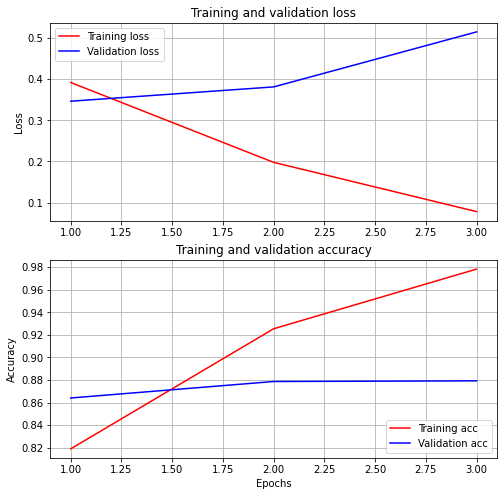

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.29256429253292404, 'init_lr': 3.7379956662233806e-06}
Epoch 1/3
625/625 [==============================] - 398s 615ms/step - loss: 0.5225 - binary_accuracy: 0.7442 - val_loss: 0.3417 - val_binary_accuracy: 0.8476
Epoch 2/3
625/625 [==============================] - 383s 613ms/step - loss: 0.3225 - binary_accuracy: 0.8614 - val_loss: 0.3258 - val_binary_accuracy: 0.8612
Epoch 3/3
625/625 [==============================] - 383s 612ms/step - loss: 0.2884 - binary_accuracy: 0.8781 - val_loss: 0.3271 - val_binary_accuracy: 0.8624


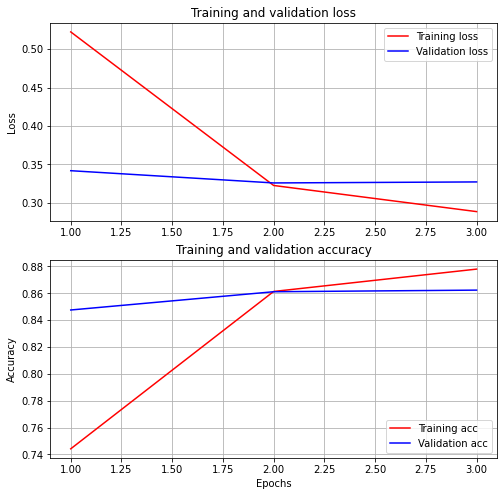

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.0606829971661115, 'init_lr': 5.200013575528651e-06}
Epoch 1/3
625/625 [==============================] - 398s 615ms/step - loss: 0.4488 - binary_accuracy: 0.7928 - val_loss: 0.3202 - val_binary_accuracy: 0.8598
Epoch 2/3
625/625 [==============================] - 383s 613ms/step - loss: 0.2863 - binary_accuracy: 0.8780 - val_loss: 0.3124 - val_binary_accuracy: 0.8670
Epoch 3/3
625/625 [==============================] - 383s 613ms/step - loss: 0.2520 - binary_accuracy: 0.8975 - val_loss: 0.3178 - val_binary_accuracy: 0.8746


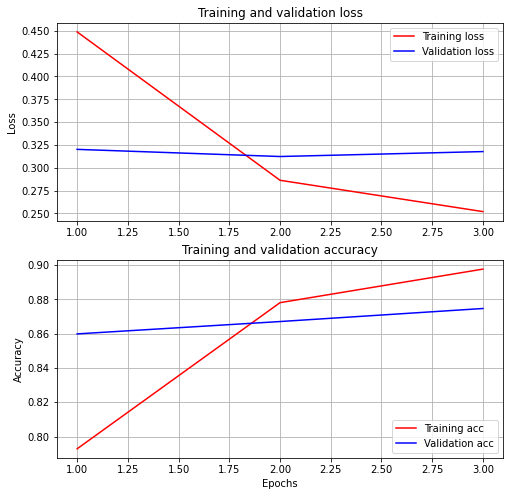

In [ ]:
classifier_model_list = []
val_acc_list = []
runtime_list = []
param_list = []

for i in range(3):
    params = get_random_params(params = {}, lr_range = (-3.5,-5.5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

In [ ]:
from google.colab import files
import pandas as pd 

df = pd.DataFrame.from_dict(param_list)
df['runtime'] = runtime_list
df['val_acc'] = val_acc_list
df['Model'] = classifier_model_list
df.to_csv("model_comparison.csv") 
files.download("model_comparison.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


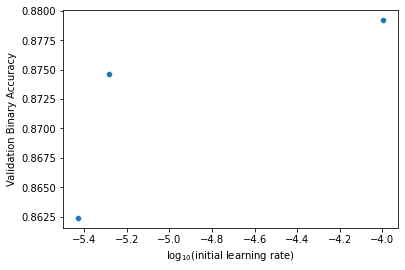

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


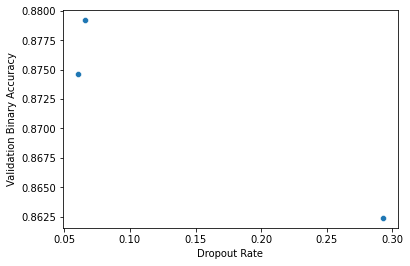

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


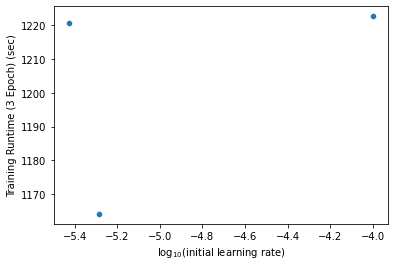

In [ ]:
sns.scatterplot(np.log10(df.init_lr), df.val_acc)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Binary Accuracy')
plt.show()

sns.scatterplot(df.dropout_rate, df.val_acc)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Binary Accuracy')
plt.show()

sns.scatterplot(np.log10(df.init_lr), df.runtime)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (3 Epoch) (sec)')
plt.show()

In [ ]:
df = pd.read_csv("model_comparison_imdb.csv")

In [ ]:
df

,Unnamed: 0,dropout_rate,init_lr,runtime,val_acc,Model
0,0,0.065645,0.000100,1222.622728,0.8792,<keras.engine.functional.Functional object at ...
1,1,0.292564,0.000004,1220.641780,0.8624,<keras.engine.functional.Functional object at ...
2,2,0.060683,0.000005,1164.150276,0.8746,<keras.engine.functional.Functional object at ...
3,3,0.280994,0.000184,1236.245891,0.8734,<keras.engine.functional.Functional object at ...
4,4,0.021925,0.000131,1170.707728,0.8778,<keras.engine.functional.Functional object at ...
5,5,0.093675,0.000027,1226.108691,0.8832,<keras.engine.functional.Functional object at ...


In [ ]:
list(df.iloc[:, 1:3].to_dict(orient='index').values())

[{'dropout_rate': 0.065645291, 'init_lr': 0.000100294},
 {'dropout_rate': 0.292564293, 'init_lr': 3.74e-06},
 {'dropout_rate': 0.060682997, 'init_lr': 5.2e-06},
 {'dropout_rate': 0.2809941875923082, 'init_lr': 0.0001835590438871},
 {'dropout_rate': 0.0219245553982674, 'init_lr': 0.0001309674198958},
 {'dropout_rate': 0.0936745563229836, 'init_lr': 2.667714852154449e-05}]

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.28099418759230826, 'init_lr': 0.00018355904388717885}
Epoch 1/3
625/625 [==============================] - 409s 629ms/step - loss: 0.4274 - binary_accuracy: 0.8037 - val_loss: 0.3440 - val_binary_accuracy: 0.8604
Epoch 2/3
625/625 [==============================] - 385s 616ms/step - loss: 0.2365 - binary_accuracy: 0.9101 - val_loss: 0.3598 - val_binary_accuracy: 0.8676
Epoch 3/3
625/625 [==============================] - 385s 616ms/step - loss: 0.0926 - binary_accuracy: 0.9707 - val_loss: 0.6085 - val_binary_accuracy: 0.8734


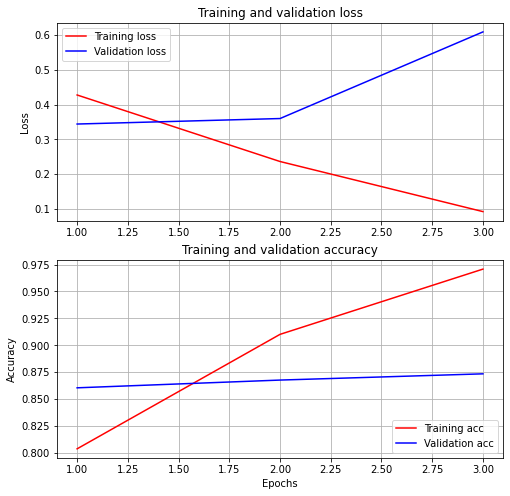

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.021924555398267476, 'init_lr': 0.00013096741989583193}
Epoch 1/3
625/625 [==============================] - 401s 618ms/step - loss: 0.3978 - binary_accuracy: 0.8288 - val_loss: 0.3149 - val_binary_accuracy: 0.8668
Epoch 2/3
625/625 [==============================] - 385s 616ms/step - loss: 0.2069 - binary_accuracy: 0.9214 - val_loss: 0.3904 - val_binary_accuracy: 0.8710
Epoch 3/3
625/625 [==============================] - 385s 615ms/step - loss: 0.0822 - binary_accuracy: 0.9739 - val_loss: 0.5288 - val_binary_accuracy: 0.8778


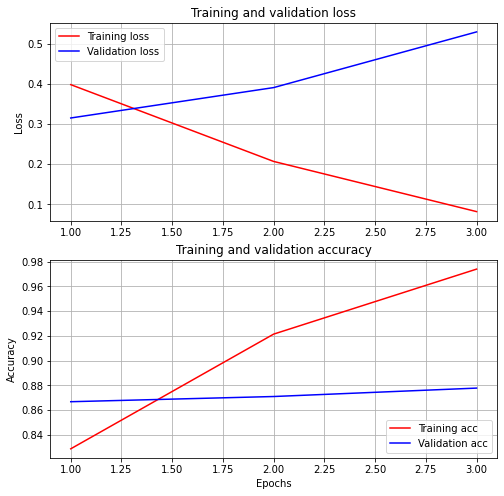

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.09367455632298363, 'init_lr': 2.667714852154449e-05}
Epoch 1/3
625/625 [==============================] - 400s 617ms/step - loss: 0.3788 - binary_accuracy: 0.8329 - val_loss: 0.2923 - val_binary_accuracy: 0.8788
Epoch 2/3
625/625 [==============================] - 385s 616ms/step - loss: 0.2031 - binary_accuracy: 0.9209 - val_loss: 0.3110 - val_binary_accuracy: 0.8868
Epoch 3/3
625/625 [==============================] - 385s 616ms/step - loss: 0.1119 - binary_accuracy: 0.9632 - val_loss: 0.4268 - val_binary_accuracy: 0.8832


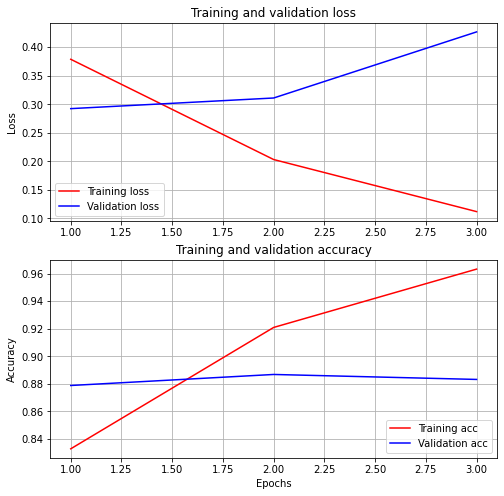

In [ ]:
classifier_model_list = list(df.Model)
val_acc_list = list(df.val_acc)
runtime_list = list(df.runtime)
param_list = list(df.iloc[:, 1:3].to_dict(orient='index').values())

for i in range(3):
    params = get_random_params(params = {}, lr_range = (-3.5,-5.5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.12945482490411747, 'init_lr': 1.0163673649661198e-05}
Epoch 1/3
625/625 [==============================] - 404s 622ms/step - loss: 0.4356 - binary_accuracy: 0.7846 - val_loss: 0.3221 - val_binary_accuracy: 0.8672
Epoch 2/3
625/625 [==============================] - 384s 614ms/step - loss: 0.2707 - binary_accuracy: 0.8907 - val_loss: 0.3062 - val_binary_accuracy: 0.8748
Epoch 3/3
625/625 [==============================] - 384s 614ms/step - loss: 0.2118 - binary_accuracy: 0.9196 - val_loss: 0.3311 - val_binary_accuracy: 0.8784


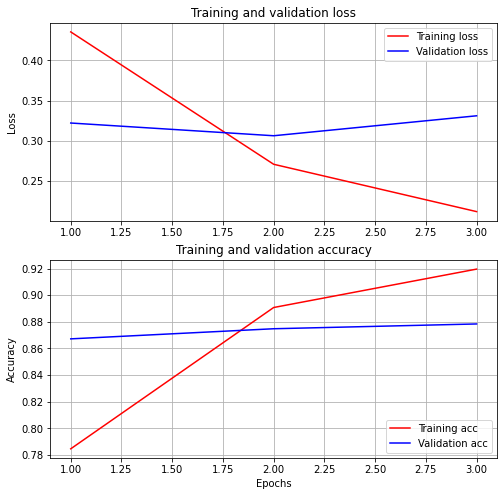

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2166691454141696, 'init_lr': 8.410294524634283e-05}
Epoch 1/3
625/625 [==============================] - 401s 617ms/step - loss: 0.3915 - binary_accuracy: 0.8313 - val_loss: 0.3014 - val_binary_accuracy: 0.8790
Epoch 2/3
625/625 [==============================] - 385s 616ms/step - loss: 0.1937 - binary_accuracy: 0.9248 - val_loss: 0.4206 - val_binary_accuracy: 0.8786
Epoch 3/3
625/625 [==============================] - 385s 615ms/step - loss: 0.0692 - binary_accuracy: 0.9785 - val_loss: 0.5511 - val_binary_accuracy: 0.8814


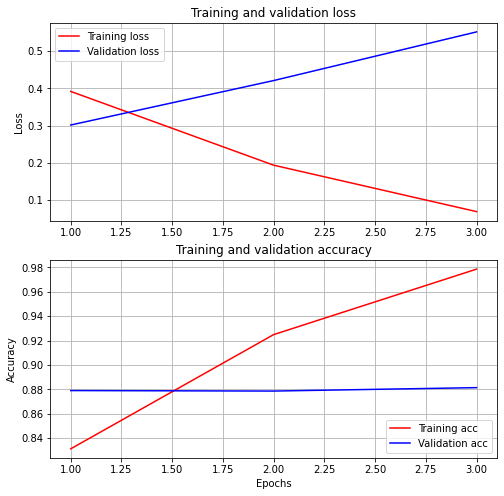

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.04768775522450613, 'init_lr': 0.00017434677113411227}
Epoch 1/3
625/625 [==============================] - 400s 616ms/step - loss: 0.4178 - binary_accuracy: 0.8238 - val_loss: 0.3538 - val_binary_accuracy: 0.8570
Epoch 2/3
625/625 [==============================] - 384s 615ms/step - loss: 0.2296 - binary_accuracy: 0.9131 - val_loss: 0.3525 - val_binary_accuracy: 0.8678
Epoch 3/3
625/625 [==============================] - 385s 616ms/step - loss: 0.0830 - binary_accuracy: 0.9735 - val_loss: 0.5178 - val_binary_accuracy: 0.8830


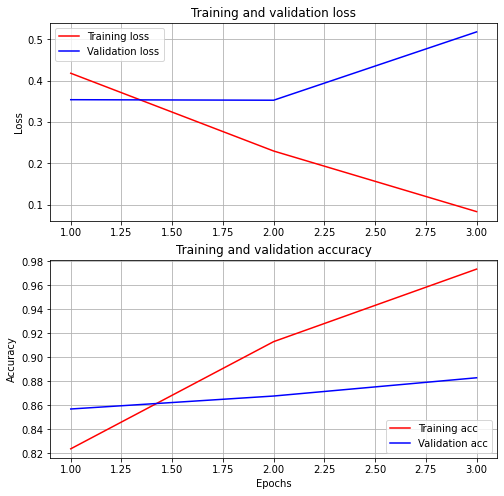

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2937037970606695, 'init_lr': 9.472897970024632e-06}
Epoch 1/3
625/625 [==============================] - 403s 620ms/step - loss: 0.4503 - binary_accuracy: 0.7933 - val_loss: 0.3187 - val_binary_accuracy: 0.8656
Epoch 2/3
625/625 [==============================] - 386s 617ms/step - loss: 0.2720 - binary_accuracy: 0.8875 - val_loss: 0.3101 - val_binary_accuracy: 0.8734
Epoch 3/3
625/625 [==============================] - 385s 617ms/step - loss: 0.2185 - binary_accuracy: 0.9148 - val_loss: 0.3262 - val_binary_accuracy: 0.8778


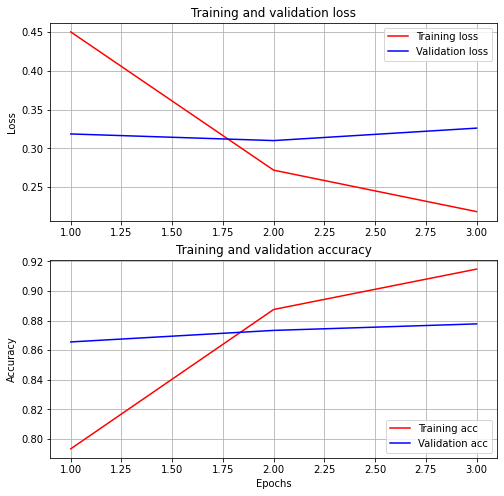

In [ ]:
classifier_model_list = list(df.Model)
val_acc_list = list(df.val_acc)
runtime_list = list(df.runtime)
param_list = list(df.iloc[:, 1:3].to_dict(orient='index').values())

for i in range(4):
    params = get_random_params(params = {}, lr_range = (-3.5,-5.5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

In [ ]:
classifier_model_list

['<keras.engine.functional.Functional object at 0x7f8edb719890>',
 '<keras.engine.functional.Functional object at 0x7f8df46ec790>',
 '<keras.engine.functional.Functional object at 0x7f8ceaad0cd0>',
 '<keras.engine.functional.Functional object at 0x7fde56edd850>',
 '<keras.engine.functional.Functional object at 0x7fde2f50a050>',
 '<keras.engine.functional.Functional object at 0x7fdc46fcf590>',

In [ ]:
from google.colab import files
import pandas as pd 

df = pd.DataFrame.from_dict(param_list)
df['runtime'] = runtime_list
df['val_acc'] = val_acc_list
df['Model'] = classifier_model_list
df.to_csv("model_comparison_imdb.csv") 
files.download("model_comparison_imdb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


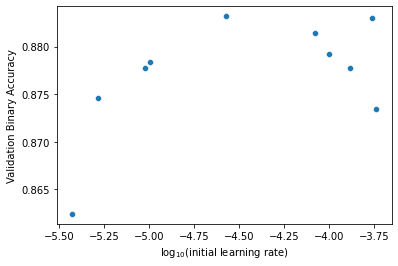

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


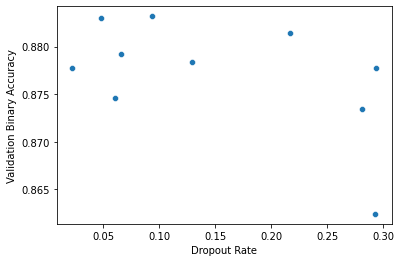

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


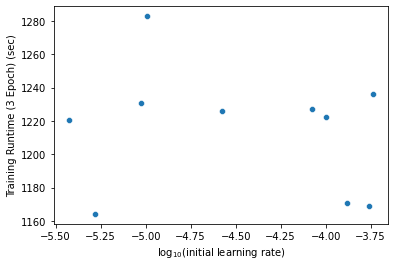

In [ ]:
import seaborn as sns
sns.scatterplot(np.log10(df.init_lr), df.val_acc)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Binary Accuracy')
plt.show()

sns.scatterplot(df.dropout_rate, df.val_acc)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Binary Accuracy')
plt.show()

sns.scatterplot(np.log10(df.init_lr), df.runtime)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (3 Epoch) (sec)')
plt.show()

### Best Model

In [ ]:
df = pd.read_csv("model_comparison_imdb.csv")
df.iloc[:, 1:5]

,dropout_rate,init_lr,runtime,val_acc
0,0.065645,0.000100,1222.622728,0.8792
1,0.292564,0.000004,1220.641780,0.8624
2,0.060683,0.000005,1164.150276,0.8746
3,0.280994,0.000184,1236.245891,0.8734
4,0.021925,0.000131,1170.707728,0.8778
5,0.093675,0.000027,1226.108691,0.8832
6,0.129455,0.000010,1282.843887,0.8784
7,0.216669,0.000084,1227.328424,0.8814
8,0.047688,0.000174,1169.054839,0.8830
9,0.293704,0.000009,1230.601533,0.8778


In [ ]:
df['runtime'] = df.runtime/60.0
df['log10_lr'] = np.log10(df.init_lr)

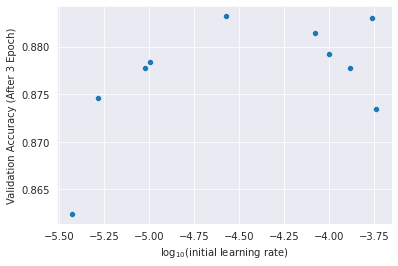

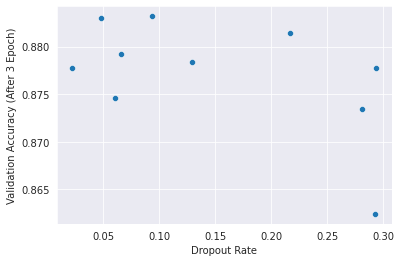

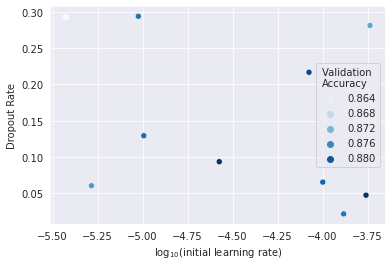

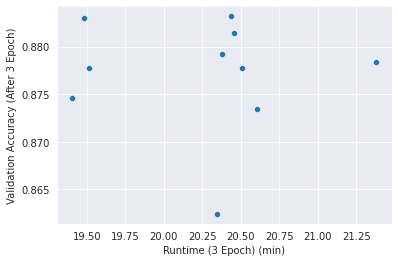

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
sns.scatterplot(x='log10_lr', y='val_acc', data= df)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Accuracy (After 3 Epoch)')
plt.show()

sns.scatterplot(x='dropout_rate', y='val_acc', data= df)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy (After 3 Epoch)')
plt.show()

sns.scatterplot(x='log10_lr', hue='val_acc', y = 'dropout_rate', data= df, palette = 'Blues')
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Dropout Rate')
plt.legend(title = 'Validation \nAccuracy')
plt.show()

sns.scatterplot(x='runtime', y='val_acc', data= df)
plt.xlabel('Runtime (3 Epoch) (min)')
plt.ylabel('Validation Accuracy (After 3 Epoch)')
plt.show()

In [ ]:
best_ind = df.val_acc.idxmax()
df.iloc[best_ind, :]

Unnamed: 0                                                      5
dropout_rate                                             0.093675
init_lr                                                  0.000027
runtime                                               1226.108691
val_acc                                                    0.8832
Model           <keras.engine.functional.Functional object at ...
Name: 5, dtype: object

In [ ]:
best_params = {'dropout_rate': df.dropout_rate[best_ind].astype('float32'),
               'init_lr':df.init_lr[best_ind].astype('float32')}
best_params

{'dropout_rate': 0.093674555, 'init_lr': 2.6677148e-05}

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.093674555, 'init_lr': 2.6677148e-05}
Epoch 1/5
625/625 [==============================] - 405s 623ms/step - loss: 0.4061 - binary_accuracy: 0.8012 - val_loss: 0.3049 - val_binary_accuracy: 0.8788
Epoch 2/5
625/625 [==============================] - 387s 619ms/step - loss: 0.2197 - binary_accuracy: 0.9124 - val_loss: 0.3391 - val_binary_accuracy: 0.8844
Epoch 3/5
625/625 [==============================] - 388s 620ms/step - loss: 0.1239 - binary_accuracy: 0.9603 - val_loss: 0.4452 - val_binary_accuracy: 0.8840
Epoch 4/5
625/625 [==============================] - 385s 615ms/step - loss: 0.0676 - binary_accuracy: 0.9811 - val_loss: 0.5457 - val_binary_accuracy: 0.8850
Epoch 5/5
625/625 [==============================] - 384s 615ms/step - loss: 0.0382 - binary_accuracy: 0.9904 - val_loss: 0.5796 - val_binary_accuracy: 0.8882


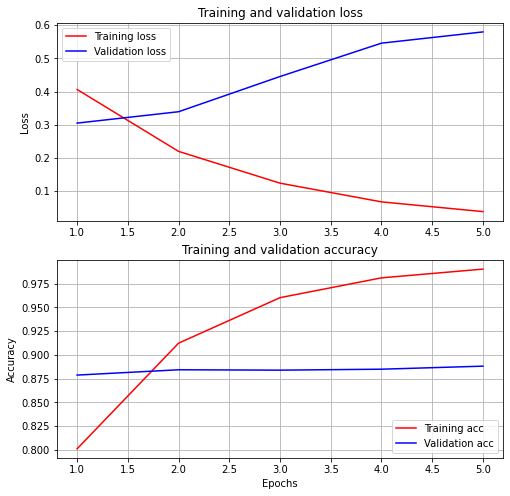

([0.8787999749183655,
  0.8844000101089478,
  0.8840000033378601,
  0.8849999904632568,
  0.8881999850273132],
 1948.223261833191)

In [ ]:
best_classifier_model, best_val_acc, best_runtime = run_NLP_model(best_params, 
                                                             epochs = 5)
best_val_acc, best_runtime

# Evaluate the final model using Test Dataset

In [ ]:
loss, accuracy = best_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 186s 237ms/step - loss: 0.5670 - binary_accuracy: 0.8872
Loss: 0.5669723153114319
Accuracy: 0.8871600031852722


In [ ]:
loss, accuracy = best_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 170s 217ms/step - loss: 0.4617 - binary_accuracy: 0.8702
Loss: 0.4617340564727783
Accuracy: 0.8701599836349487


In [ ]:
for text_batch, label_batch in test_ds.take(1):
    example_text = text_batch.numpy()[:30]

In [ ]:
print(best_classifier_model(example_text[0:1]))

tf.Tensor([[0.00293006]], shape=(1, 1), dtype=float32)


In [ ]:
def print_example_result(n = 2):
    for i in range(2):
        print(f'Text: {example_text[i]}, \t Score: {best_classifier_model(example_text[i:i+1])}')

In [ ]:
i = 10
print(str(example_text[i][:100]))
pred = best_classifier_model(example_text[i:i+1])
print(f'Score: {pred}')

b'When I read the reviews of Kahin Pyaar Na Ho Jaaye, I thought, "Huh?". It was THAT confusing. To be '
Score: [[0.00050269]]
